**Integrating Explainable Machine Learning to Predict and Identify Factors Associated with Self-Reported Depression among Adults in Tennessee, United States**

This is a machine learning project that is aimed at predicting self-reported Depression among adults in the state of Tennessee, United States of America (USA), using the Behavioral Risk Factor Surveillance System (BRFSS) 2023 data.

Load packages needed for the analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from google.colab import files

Load the dataset

In [2]:
uploaded = files.upload()

Saving Selected_BRFSS_Cleaned_Nomiss_Final.dta to Selected_BRFSS_Cleaned_Nomiss_Final.dta


**Importing the dataset and take a look at it**

In [3]:
# import Stata dataset
dhs18 = pd.read_stata('Selected_BRFSS_Cleaned_Nomiss_Final.dta', convert_categoricals=False)

In [4]:
# Take a look at the dataset
dhs18.shape

(5596, 29)

In [5]:
# Drop one of the variables in the analysis
dhs18 = dhs18.drop(columns=['poor_ment_days'])


In [6]:
dhs18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   self_health_good      5596 non-null   int8   
 1   poor_phys_days        5596 non-null   int8   
 2   has_health_insurance  5596 non-null   int8   
 3   physically_active     5596 non-null   int8   
 4   race_ethnicity_5cat   5596 non-null   int8   
 5   sex                   5596 non-null   int8   
 6   age_group_6cat        5596 non-null   int8   
 7   bmi_category          5596 non-null   int8   
 8   num_children          5596 non-null   int8   
 9   education_level       5596 non-null   int8   
 10  smoking_status        5596 non-null   int8   
 11  drank_past_30d        5596 non-null   int8   
 12  depression_dx         5596 non-null   int8   
 13  home_ownership        5596 non-null   int8   
 14  veteran_status        5596 non-null   int8   
 15  pregnant_status      

In [7]:
dhs18.columns

Index(['self_health_good', 'poor_phys_days', 'has_health_insurance',
       'physically_active', 'race_ethnicity_5cat', 'sex', 'age_group_6cat',
       'bmi_category', 'num_children', 'education_level', 'smoking_status',
       'drank_past_30d', 'depression_dx', 'home_ownership', 'veteran_status',
       'pregnant_status', 'urban_rural', 'memory_decline', 'is_caregiver',
       '_psu', '_ststr', '_llcpwt', 'Comorbid_Cat', 'Cancer_diagnosis',
       'ACES_Cat', 'married_binary', 'employed_binary', 'disability_Cat'],
      dtype='object')

In [8]:
# Defining the X variables
x = dhs18 [['self_health_good', 'poor_phys_days',
       'has_health_insurance', 'physically_active', 'race_ethnicity_5cat',
       'sex', 'age_group_6cat', 'bmi_category', 'num_children',
       'education_level', 'smoking_status', 'drank_past_30d',
       'home_ownership', 'veteran_status', 'pregnant_status', 'urban_rural',
       'memory_decline', 'is_caregiver', 'Comorbid_Cat', 'Cancer_diagnosis',
       'ACES_Cat', 'married_binary', 'employed_binary', 'disability_Cat']]

In [9]:
# Take a look at the X variables
x.shape

(5596, 24)

In [10]:
# Checking for missing values
x.isnull().sum()

,0
self_health_good,0
poor_phys_days,0
has_health_insurance,0
physically_active,0
race_ethnicity_5cat,0
sex,0
age_group_6cat,0
bmi_category,0
num_children,0
education_level,0


In [11]:
# Defining the Y variable in the analysis
y = dhs18.depression_dx

In [12]:
# Take a look at the Y variable
y.shape

(5596,)

In [13]:
y.value_counts()

,count
depression_dx,
0,4072
1,1524


In [14]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5596 entries, 0 to 5595
Series name: depression_dx
Non-Null Count  Dtype
--------------  -----
5596 non-null   int8 
dtypes: int8(1)
memory usage: 5.6 KB


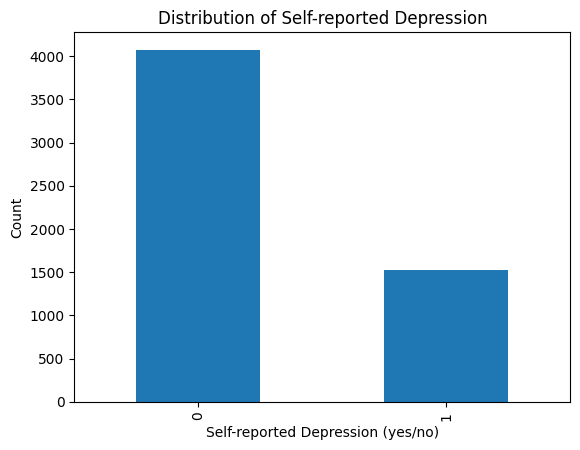

In [15]:
# prompt: plot a plot for the y.value_counts
y.value_counts().plot(kind='bar')
plt.title('Distribution of Self-reported Depression')
plt.xlabel('Self-reported Depression (yes/no)')
plt.ylabel('Count')
plt.show()

**Checking for Multicollinearity between the variables**

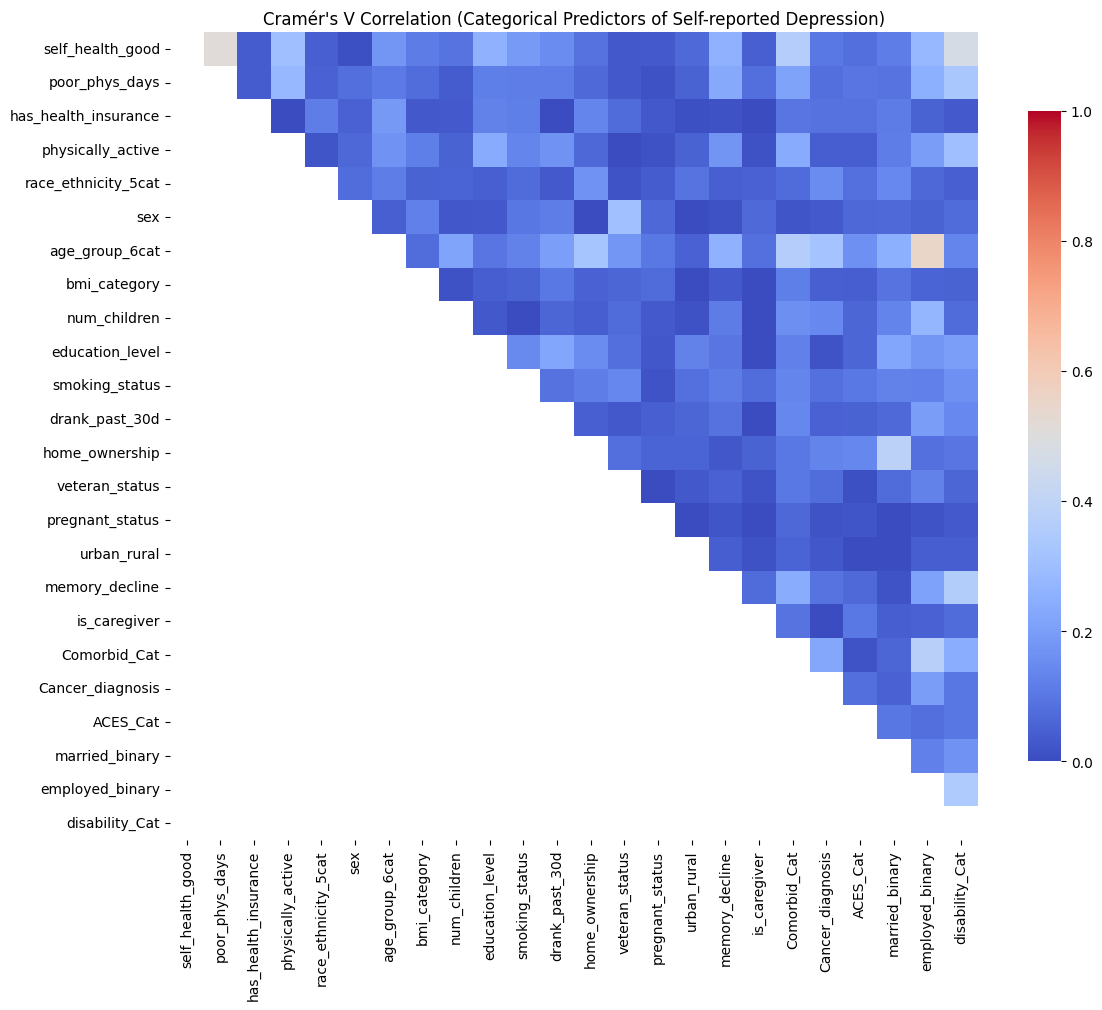


Pairs with Cramér's V ≥ 0.7 (possible redundancy):
  None at or above threshold.


In [16]:
# ==== Multicollinearity among categorical predictors via Cramér's V ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1) Cramér's V (bias-corrected) for two categorical Series
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    tbl = pd.crosstab(x, y, dropna=False)
    # Need at least 2x2 table with variation
    if tbl.shape[0] < 2 or tbl.shape[1] < 2:
        return 0.0
    chi2 = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = tbl.shape
    # Bias correction (Bergsma 2013)
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

# 2) Ensure everything in X is treated as categorical (string safe-cast)
X_cat = x.copy().astype("category").apply(lambda s: s.astype(str)).fillna("Missing")

cols = X_cat.columns.tolist()
n = len(cols)
cramers = pd.DataFrame(np.eye(n), index=cols, columns=cols)

for i in range(n):
    for j in range(i + 1, n):
        v = cramers_v(X_cat.iloc[:, i], X_cat.iloc[:, j])
        cramers.iat[i, j] = v
        cramers.iat[j, i] = v

# 3) Heatmap (upper triangle)
mask = np.tril(np.ones_like(cramers, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(cramers, mask=mask, cmap="coolwarm", vmin=0, vmax=1,
            square=True, cbar_kws={"shrink": 0.8})
plt.title("Cramér's V Correlation (Categorical Predictors of Self-reported Depression)")
plt.tight_layout()
plt.show()

# 4) Print the strongest pairs (adjust threshold as needed)
THRESH = 0.7  # <-- set your concern threshold here
pairs = []
for i in range(n):
    for j in range(i + 1, n):
        pairs.append((cols[i], cols[j], cramers.iat[i, j]))
strong_pairs = sorted([p for p in pairs if p[2] >= THRESH], key=lambda x: x[2], reverse=True)

print(f"\nPairs with Cramér's V ≥ {THRESH} (possible redundancy):")
if strong_pairs:
    for a, b, v in strong_pairs:
        print(f"  {a}  ~  {b}:  {v:.2f}")
else:
    print("  None at or above threshold.")

# Optional: save matrix for appendix/supplement
# cramers.to_csv("cramers_v_matrix.csv", index=True)


**Apply the Synthetic Minority Over-sampling Technique (SMOTE)**

Class balance (full):
depression_dx
0    4072
1    1524
Name: count, dtype: int64 

Train before SMOTE:
depression_dx
0    3257
1    1219
Name: count, dtype: int64

Test (never resampled):
depression_dx
0    815
1    305
Name: count, dtype: int64

Train after SMOTE:
depression_dx
1    3257
0    3257
Name: count, dtype: int64


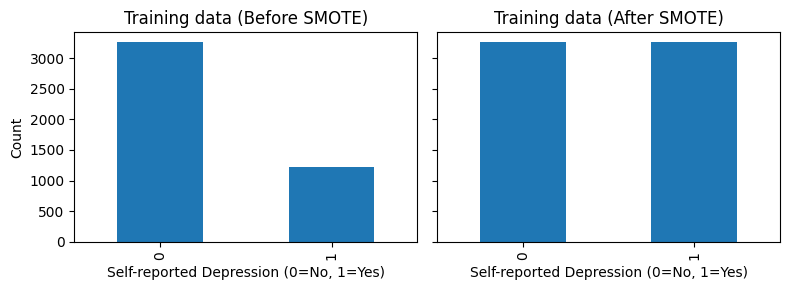

In [17]:
# ==== SMOTE on TRAIN ONLY for all-categorical predictors ====
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1) Train/test split (test stays untouched by SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42, stratify=y
)

print("Class balance (full):")
print(y.value_counts(), "\n")
print("Train before SMOTE:")
print(y_train.value_counts())
print("\nTest (never resampled):")
print(y_test.value_counts())

# 2) Preprocess: impute most-frequent + one-hot for ALL columns (all are categorical)
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             # FIX: use sparse_output=False (new sklearn >=1.2)
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         x.columns.tolist()
        )
    ],
    remainder="drop"
)

# 3) Build pipeline: transform -> SMOTE   (no classifier yet)
smote_pipe = ImbPipeline(steps=[
    ("prep", preprocess_cat),
    ("smote", SMOTE(random_state=42))
])

# 4) Fit-resample on TRAINING ONLY
X_resampled, y_resampled = smote_pipe.fit_resample(X_train, y_train)

print("\nTrain after SMOTE:")
print(y_resampled.value_counts())

# 5) Quick bar plots for train counts before/after
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
y_train.value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Training data (Before SMOTE)")
y_resampled.value_counts().sort_index().plot(kind="bar", ax=axes[1], title="Training data (After SMOTE)")
for ax in axes:
    ax.set_xlabel("Self-reported Depression (0=No, 1=Yes)")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

**Cross-validation For the Analysis**

In [18]:
# ==== Cross-validation setup (before model building) ====
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Preprocess (all predictors are categorical)
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         x.columns.tolist()
        )
    ],
    remainder="drop"
)

# Model
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced")

# Pipeline: preprocess -> SMOTE (train folds only) -> model
rf_pipe = ImbPipeline(steps=[
    ("prep", preprocess_cat),
    ("smote", SMOTE(random_state=42)),
    ("clf", rf)
])

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_pipe, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"CV accuracies: {np.round(cv_scores, 4)}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"SD: {cv_scores.std():.4f}")


CV accuracies: [0.7556 0.7709 0.7899 0.7676 0.7765]
Mean accuracy: 0.7721
SD: 0.0112


**Model Building and Evaluation as well as Recursive Feature Elimination (RFE)**

In [19]:
# ==== Build & evaluate models with SMOTE + RFE nested inside 5-fold CV, then test on hold-out set ====

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

import numpy as np
import pandas as pd

RANDOM_STATE = 42

# -----------------------------
# 1) Preprocess: all predictors categorical
# -----------------------------
preprocess_cat = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("impute", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # sklearn ≥1.2
         ]),
         X_train.columns.tolist()  # <-- use X_train columns
        )
    ],
    remainder="drop"
)

# -----------------------------
# 2) RFE selector (inside CV)
#    Use LR as the feature-ranking estimator so it works for any downstream model
# -----------------------------
rfe_ranker = LogisticRegression(
    max_iter=3000,
    solver="liblinear",   # stable for smaller/medium OHE matrices
    random_state=RANDOM_STATE
)

# RFE itself (n_features_to_select will be tuned in CV)
rfe = RFE(
    estimator=rfe_ranker,
    n_features_to_select=50,  # placeholder; tuned by GridSearchCV
    step=0.1                  # drop 10% each iteration (faster than step=1)
)

def make_pipe(est):
    # All steps happen inside CV folds when used in GridSearchCV
    return ImbPipeline(steps=[
        ("prep", preprocess_cat),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("rfe", rfe),
        ("clf", est)
    ])

# -----------------------------
# 3) Models + tuning grids
#    (Keep grids modest; expand if you want deeper tuning)
# -----------------------------
models_and_grids = {
    "LR": (
        LogisticRegression(max_iter=3000, solver="lbfgs"),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__C": [0.1, 1.0, 10.0]
        }
    ),
    "NB": (
        BernoulliNB(),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__alpha": [0.1, 1.0, 2.0]
        }
    ),
    "SVM": (
        SVC(kernel="rbf", probability=True, gamma="scale", random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__C": [0.5, 1.0, 2.0]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__n_neighbors": [5, 15, 25]
        }
    ),
    "DT": (
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__max_depth": [None, 5, 10],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    ),
    "RF": (
        RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    ),
    "GB": (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__learning_rate": [0.05, 0.1],
            "clf__n_estimators": [100, 300]
        }
    ),
    "XGB": (
        XGBClassifier(
            eval_metric="auc",
            tree_method="hist",
            random_state=RANDOM_STATE
        ),
        {
            "rfe__n_features_to_select": [30, 50, 80, 120],
            "clf__n_estimators": [200, 600],
            "clf__max_depth": [3, 4],
            "clf__learning_rate": [0.05, 0.1],
            "clf__subsample": [0.8, 0.9],
            "clf__colsample_bytree": [0.8, 0.9]
        }
    )
}

# -----------------------------
# 4) CV setup (training only)
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
fitted = {}
best_params_store = {}

for name, (est, param_grid) in models_and_grids.items():
    pipe = make_pipe(est)

    # Grid search: RFE + model tuning happens INSIDE CV folds
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    gs.fit(X_train, y_train)   # trains only on training data (with internal CV)
    best_model = gs.best_estimator_
    fitted[name] = best_model
    best_params_store[name] = gs.best_params_

    # ---- Test-set evaluation (untouched test set) ----
    if hasattr(best_model, "predict_proba"):
        proba = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        scores = best_model.decision_function(X_test)
        proba = 1 / (1 + np.exp(-scores))
    else:
        proba = None

    pred = best_model.predict(X_test)

    row = {
        "Model": name,
        "CV_best_AUROC": gs.best_score_,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
        "BalancedAcc": balanced_accuracy_score(y_test, pred)
    }

    if proba is not None:
        row.update({
            "AUROC": roc_auc_score(y_test, proba),
            "PR-AUC": average_precision_score(y_test, proba)
        })
    else:
        row.update({"AUROC": np.nan, "PR-AUC": np.nan})

    rows.append(row)

results_df = pd.DataFrame(rows).sort_values("AUROC", ascending=False)

print("\nHold-out Test Performance (unresampled test set; RFE+SMOTE+tuning nested within CV on training only):")
display(results_df.round(3))

print("\nBest parameters selected by CV (includes RFE feature count):")
for k, v in best_params_store.items():
    print(f"{k}: {v}")

# -----------------------------
# 5) Detailed report for best test-set model
# -----------------------------
best_name = results_df.iloc[0]["Model"]
best = fitted[best_name]
best_pred = best.predict(X_test)

print(f"\n=== Detailed report for best model on hold-out test set: {best_name} ===")
print(classification_report(y_test, best_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, best_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=80 > n_features=70. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=80 > n_features=70. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=80 > n_features=70. There will be no feature selection and all features will be kept.
  warnings.warn(



Hold-out Test Performance (unresampled test set; RFE+SMOTE+tuning nested within CV on training only):


,Model,CV_best_AUROC,Accuracy,Precision,Recall,F1,BalancedAcc,AUROC,PR-AUC
7,XGB,0.796,0.765,0.582,0.489,0.531,0.679,0.787,0.612
6,GB,0.794,0.772,0.598,0.502,0.545,0.688,0.784,0.608
5,RF,0.787,0.776,0.595,0.554,0.574,0.706,0.783,0.614
0,LR,0.797,0.723,0.494,0.702,0.580,0.716,0.782,0.612
2,SVM,0.784,0.760,0.555,0.597,0.575,0.709,0.781,0.594
1,NB,0.779,0.726,0.497,0.630,0.556,0.696,0.769,0.577
3,KNN,0.755,0.697,0.462,0.679,0.550,0.691,0.757,0.537
4,DT,0.744,0.744,0.531,0.508,0.519,0.670,0.745,0.518



Best parameters selected by CV (includes RFE feature count):
LR: {'clf__C': 0.1, 'rfe__n_features_to_select': 30}
NB: {'clf__alpha': 2.0, 'rfe__n_features_to_select': 30}
SVM: {'clf__C': 0.5, 'rfe__n_features_to_select': 80}
KNN: {'clf__n_neighbors': 25, 'rfe__n_features_to_select': 30}
DT: {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'rfe__n_features_to_select': 30}
RF: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'rfe__n_features_to_select': 80}
GB: {'clf__learning_rate': 0.1, 'clf__n_estimators': 100, 'rfe__n_features_to_select': 30}
XGB: {'clf__colsample_bytree': 0.9, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.8, 'rfe__n_features_to_select': 80}

=== Detailed report for best model on hold-out test set: XGB ===
              precision    recall  f1-score   support

           0      0.819     0.869     0.843       815
           1      0.582     0.489     0.531       305

    accuracy                          0.765     

**For Extreme Gradient Boosting Model**

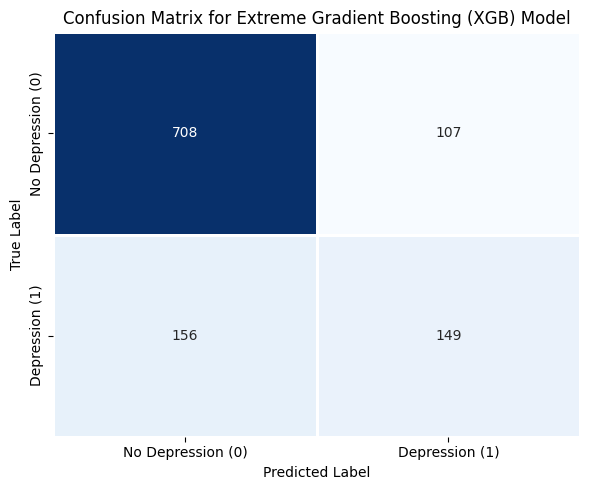


Specificity (True Negative Rate): 0.869
Sensitivity (True Positive Rate): 0.489


In [20]:
# ==== Confusion Matrix for the Best Model (Extreme Gradient Boosting (XGB) Model) ====

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class labels using the best model (LR)
y_pred_best = (best.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

labels = ["No Depression (0)", "Depression (1)"]

# Heatmap visualization
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels,
    cbar=False, linewidths=1
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Extreme Gradient Boosting (XGB) Model")
plt.tight_layout()
plt.show()

# Optional: Class-wise performance rates
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nSpecificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")

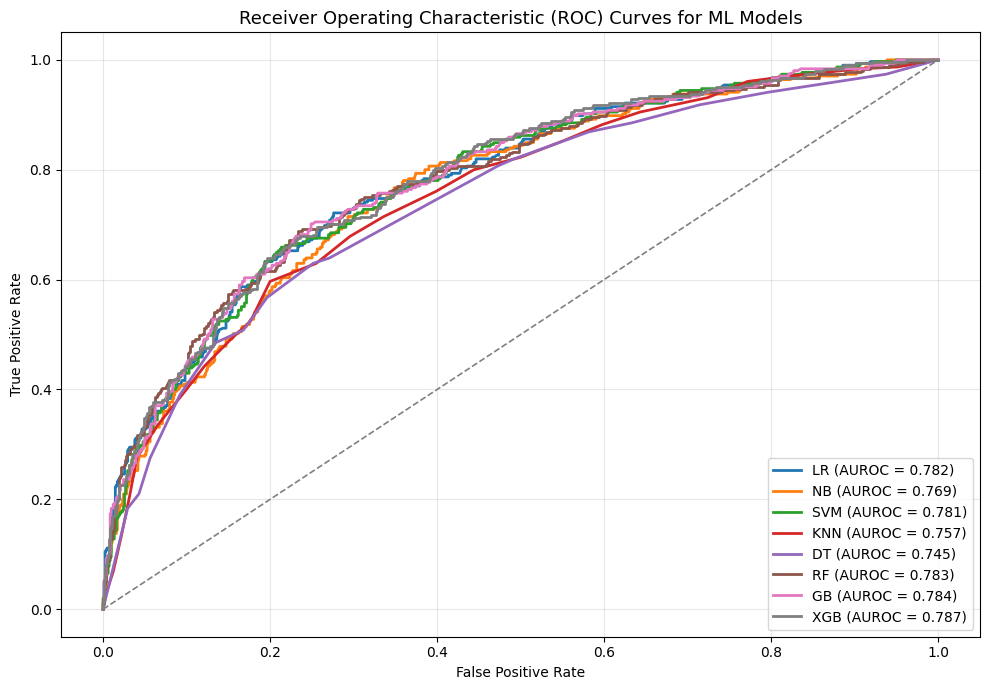

In [21]:
# ==== ROC Curves for All Models ====
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

# Use the fitted dictionary of trained pipelines from your previous step
for name, model in fitted.items():
    # Predict probabilities for positive class
    y_score = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and area under curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUROC = {roc_auc:.3f})')

# Add chance line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1.2)

# Styling
plt.title('Receiver Operating Characteristic (ROC) Curves for ML Models', fontsize=13)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


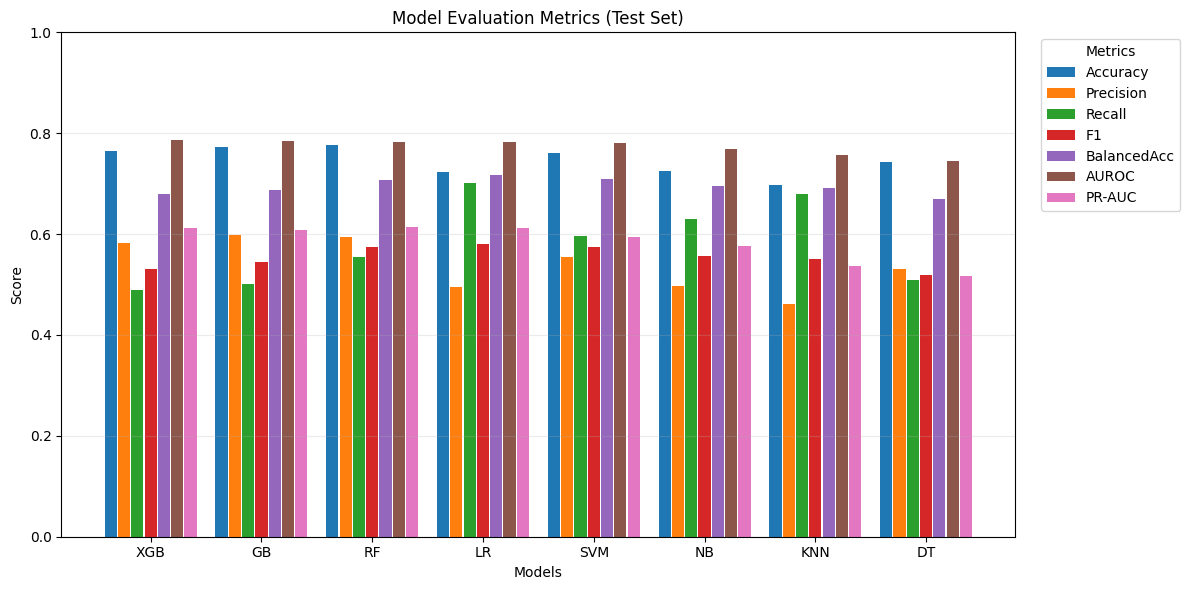

In [22]:
# ==== Grouped bar chart of model metrics (incl. BalancedAcc, PR-AUC) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you already have results_df from earlier, use it; otherwise build it from your lists.
# results_df should have columns: Model, Accuracy, Precision, Recall, F1, BalancedAcc, AUROC, PR-AUC
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "BalancedAcc", "AUROC", "PR-AUC"]

plot_df = results_df.set_index("Model")[metrics_to_plot].copy()
model_names = plot_df.index.tolist()
M = len(model_names)
K = len(metrics_to_plot)

# Bar positions
x = np.arange(M)
bar_w = 0.11
offsets = (np.arange(K) - (K-1)/2) * (bar_w + 0.01)

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + offsets[i], plot_df[metric].values, width=bar_w, label=metric)

# Labels & styling
plt.xticks(x, model_names, rotation=0, fontsize=10)
plt.ylim(0, 1.0)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Evaluation Metrics (Test Set)")
plt.legend(title="Metrics", loc="upper left", bbox_to_anchor=(1.02, 1))
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Initialize list for results
conf_list = []

# Loop through all trained models
for name, model in fitted.items():
    # Predict on test data
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    conf_list.append({
        "Model": name,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

# Convert to DataFrame
conf_df = pd.DataFrame(conf_list)

# Order the models in the same order as before (optional)
model_order = ["LR", "SVM", "KNN", "DT", "NB", "RF", "GB", "XGB"]
conf_df = conf_df.set_index("Model").loc[model_order].reset_index()

# Display the table
print("\nConfusion Matrix Counts (Test Set)")
display(conf_df)



Confusion Matrix Counts (Test Set)


,Model,TP,FP,FN,TN
0,LR,214,219,91,596
1,SVM,189,155,116,660
2,KNN,207,241,98,574
3,DT,155,137,150,678
4,NB,192,194,113,621
5,RF,169,115,136,700
6,GB,153,103,152,712
7,XGB,149,107,156,708


**SHapley Additive exPlanations (SHAP) Analysis**

**SHAP Analysis using Extreme Gradient Boosting (XGB) Model**

Top variables by aggregated mean |SHAP| values (XGB Depression model):


,base,mean_abs_shap
3,age_group_6cat,0.503271
5,disability_Cat,0.493986
0,ACES_Cat,0.465441
20,sex,0.423825
16,poor_phys_days,0.317208
2,Comorbid_Cat,0.294481
12,married_binary,0.173676
13,memory_decline,0.142265
18,race_ethnicity_5cat,0.141778
6,drank_past_30d,0.127509


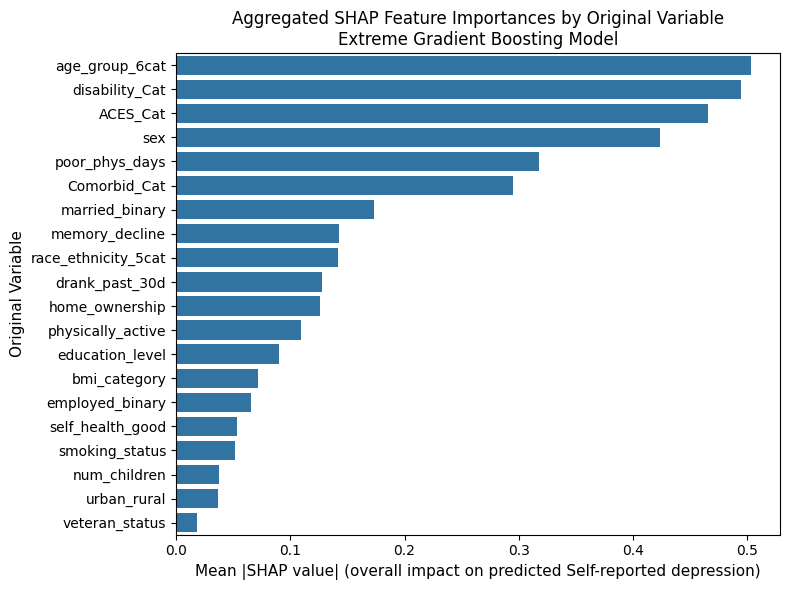


Number of original variables (groups): 24


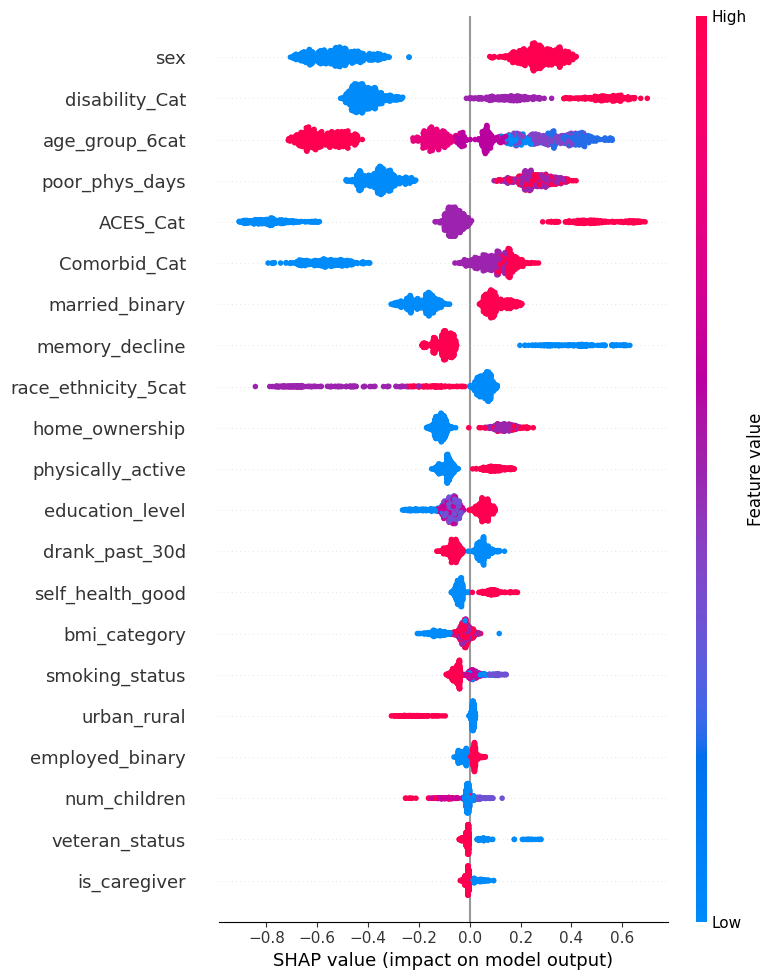

In [24]:
# ==== Aggregated SHAP Feature Importance + Grouped Beeswarm for XGB (Depression model) ====
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# -------------------------------------------------------------------
# 0) Pull GB pipeline and build SHAP explainer
# -------------------------------------------------------------------
# Assumes:
#   fitted["XGB"] -> trained XGB pipeline (prep + smote + clf)
#   X_test       -> original test DataFrame (same columns used in training)
#   y_test       -> binary outcome (0/1)

# --- 0) Pull fitted XGB pipeline ---
xgb_pipe = fitted["XGB"]
prep = xgb_pipe.named_steps["prep"]   # ColumnTransformer (impute + OHE)
clf  = xgb_pipe.named_steps["clf"]    # XGBClassifier

# Transform X_test (no SMOTE at inference)
X_test_tx = prep.transform(X_test)

# Get original feature names used by the transformer (works even if you didn't define `predictors`)
feature_cols = prep.feature_names_in_.tolist() if hasattr(prep, "feature_names_in_") else X_test.columns.tolist()

# Get post-encoding feature names
oh = prep.named_transformers_["cat"].named_steps["onehot"]
feat_names = list(oh.get_feature_names_out(input_features=feature_cols))

# TreeExplainer for GB
explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X_test_tx)

# Handle binary output shapes across SHAP versions
# - Sometimes returns (n_samples, n_features)
# - Sometimes returns list [class0, class1]
# - Sometimes returns (n_samples, n_features, n_classes)
if isinstance(shap_vals, list):
    shap_vals_pos = shap_vals[1]
elif getattr(shap_vals, "ndim", 0) == 3:
    shap_vals_pos = shap_vals[:, :, 1]
else:
    shap_vals_pos = shap_vals

# -------------------------------------------------------------------
# 1) Aggregate SHAP values by original variable (post-OHE groups)
# -------------------------------------------------------------------
def base_var(name: str) -> str:
    """
    Convert one-hot feature names like:
      'race_ethnicity_5cat_3' or 'sex_1'
    back to the original variable name.

    This is robust to underscores in the original variable name.
    """
    # SHAP/Sklearn OHE uses pattern: "<original>_<category>"
    # We strip the last "_<category>" chunk.
    if "_" in name:
        return name.rsplit("_", 1)[0]
    return name

mean_abs = np.mean(np.abs(shap_vals_pos), axis=0)

agg = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
      .assign(base=lambda d: d["feature"].map(base_var))
      .groupby("base", as_index=False)["mean_abs_shap"].sum()
      .sort_values("mean_abs_shap", ascending=False)
)

print("Top variables by aggregated mean |SHAP| values (XGB Depression model):")
display(agg.head(21))

# -------------------------------------------------------------------
# 2) Bar plot of aggregated SHAP importances (original variables)
# -------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=agg.head(20),
    x="mean_abs_shap",
    y="base"
)
plt.title(
    "Aggregated SHAP Feature Importances by Original Variable\nExtreme Gradient Boosting Model",
)
plt.xlabel("Mean |SHAP value| (overall impact on predicted Self-reported depression)", fontsize=11)
plt.ylabel("Original Variable", fontsize=11)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3) Grouped SHAP beeswarm at original-variable level
# -------------------------------------------------------------------
# Build mapping from encoded features -> base variable
groups = {}
for idx, fname in enumerate(feat_names):
    b = base_var(fname)
    groups.setdefault(b, []).append(idx)

base_vars = list(groups.keys())
print(f"\nNumber of original variables (groups): {len(base_vars)}")

# Build grouped SHAP matrix: sum SHAP over one-hot columns for each original variable
n_samples = shap_vals_pos.shape[0]
shap_grouped = np.zeros((n_samples, len(base_vars)))

for j, b in enumerate(base_vars):
    cols = groups[b]
    shap_grouped[:, j] = shap_vals_pos[:, cols].sum(axis=1)

# Build a matching X matrix (original variables) for coloring in beeswarm
# (convert categories -> integer codes)
X_grouped = X_test[base_vars].copy()
for col in X_grouped.columns:
    X_grouped[col] = X_grouped[col].astype("category").cat.codes

# Beeswarm plot at original-variable level
shap.summary_plot(
    shap_grouped,
    X_grouped.values,
    feature_names=base_vars,
    max_display=21,
    show=True
)
